In [ ]:
# Run CPU-only, GPU code needs further testing
"""
Restart kernel after running
Only need to run once
"""
!pip install scikit-learn matplotlib seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
import wandb


froot = './data/k562_samp_epft_norm_test_1.csv'

df = pd.read_csv(froot)

/grid/it/data/elzar/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/grid/siepel/home_norepl/hassett/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
print(df.head())

  seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0       15  88623545  88623545      +  ENSG00000181026    0.0 -0.079992   
1       15  88623546  88623546      +  ENSG00000181026    0.0 -0.079942   
2       15  88623547  88623547      +  ENSG00000181026    0.0 -0.079893   
3       15  88623548  88623548      +  ENSG00000181026    0.0 -0.079844   
4       15  88623549  88623549      +  ENSG00000181026    0.0 -0.079796   

   h3k36me3   h3k4me1  h3k79me2   h3k9me1   h3k9me3  h4k20me1       sj5  \
0 -0.000099  0.348531  4.423451  0.446508 -0.168099  3.232475 -0.028916   
1  0.001638  0.352677  4.460072  0.453024 -0.169218  3.259194 -0.028916   
2  0.003360  0.356807  4.496664  0.459491 -0.170339  3.285849 -0.028916   
3  0.005065  0.360919  4.533223  0.465908 -0.171461  3.312435 -0.028916   
4  0.006754  0.365013  4.569743  0.472274 -0.172584  3.338952 -0.028916   

        sj3       dms  wgbs      rpts  lambda_alphaj      zeta  
0 -0.057178 -0.307549   0.0  0.24

In [3]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]
num_features = len(feature_names)
#nucleotides = column_names[-6:-2]
print(feature_names)
#print(nucleotides)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['ctcf' 'h3k36me3' 'h3k4me1' 'h3k79me2' 'h3k9me1' 'h3k9me3' 'h4k20me1'
 'sj5' 'sj3' 'dms' 'wgbs' 'rpts']


In [4]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 16182613


In [5]:
print("Number of Features: " + str(num_features))

Number of Features: 12


In [6]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values
Y_ji_shape = Y_ji.shape
print(Y_ji.shape)

(16182613, 12)


In [7]:
C_j = df['lambda_alphaj'].values

In [8]:
gene_ids = df['ensembl_gene_id'].values

In [9]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: True
Number of GPUs available: 1


In [10]:
class GeneDataset(Dataset):
    def __init__(self, batches):
        self.batches = batches
        self.cache = {}

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        
        batch = self.batches[idx]
        gene_id = batch['GeneId'].values[0]
                
        y_ji_array = np.array(batch['Y_ji'].tolist()).reshape(-1, 12)
        y_ji_tensor = torch.tensor(y_ji_array, dtype=torch.float64)
            
        data = batch.drop(columns=['GeneId', 'dataset', 'Y_ji'])
        tensor_data = torch.tensor(data.values, dtype=torch.float64)
    
        result = {
            'GeneId': batch['GeneId'].values[0],
            'Y_ji': y_ji_tensor,
        }
        for col in data.columns:
            result[col] = tensor_data[:, data.columns.get_loc(col)]
            
        self.cache[idx] = result

        return result

In [11]:
from sklearn.model_selection import train_test_split

data = pd.DataFrame({
    'GeneId': gene_ids,
    'Y_ji': [row for row in Y_ji],
    'X_ji': X_ji,
    'C_j': C_j,
    'Z_ji': Z_ji
})

grouped = data.groupby('GeneId')

train_idx, temp_idx = train_test_split(list(grouped.groups.keys()), test_size=0.2, random_state=42)

val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

dataset_mapping = {gene_id: 'train' for gene_id in train_idx}
dataset_mapping.update({gene_id: 'val' for gene_id in val_idx})
dataset_mapping.update({gene_id: 'test' for gene_id in test_idx})

data['dataset'] = data['GeneId'].map(dataset_mapping)

train_data = data[data['dataset'] == 'train']
val_data = data[data['dataset'] == 'val']
test_data = data[data['dataset'] == 'test']

In [12]:
print("train data size: " + str(len(train_data)))
print("val data size: " + str(len(val_data)))
print("test data size: " + str(len(test_data)))

train data size: 12713808
val data size: 1798949
test data size: 1669856


In [13]:
print("train # genes: " + str(len(train_data.groupby('GeneId'))))
print("val # genes: " + str(len(val_data.groupby('GeneId'))))
print("test # genes: " + str(len(test_data.groupby('GeneId'))))

train # genes: 415
val # genes: 52
test # genes: 52


In [14]:
def create_batches(grouped_data, max_batch_size):
    batches = []
    for _, group in grouped_data:
        if len(group) <= 2000:
            continue
        # Check if the group size exceeds the max_batch_size
        if len(group) > max_batch_size:
            # Split the group into smaller batches
            for start_idx in range(0, len(group), max_batch_size):
                end_idx = start_idx + max_batch_size
                batch = group.iloc[start_idx:end_idx]
                batches.append(batch)
        else:
            # If the group size is within the limit, add it as is
            batches.append(group)
    return batches


train_batches = create_batches(train_data.groupby('GeneId'), 64)
val_batches = create_batches(val_data.groupby('GeneId'), 64)
test_batches = create_batches(test_data.groupby('GeneId'), 64)

In [15]:
def build_dataset(train_data, batch_size):
    batches = create_batches(train_data.groupby('GeneId'), batch_size)
    dataset = GeneDataset(batches)
    loader = DataLoader(dataset, batch_size=1, num_workers=7, shuffle=False, pin_memory=True)
    return loader

In [16]:
train_dataset = GeneDataset(train_batches)
val_dataset = GeneDataset(val_batches)
test_dataset = GeneDataset(test_batches)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1, bias=False)

if cuda_available:
    """
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    """
    model = model.to('cuda')

print(model)

arr = torch.randn((64,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
model.double()

Linear(in_features=12, out_features=1, bias=False)
torch.Size([64, 1])
Number of parameters: 12
Model is on device: cuda:0


Linear(in_features=12, out_features=1, bias=False)

In [33]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        C_j_value = C_j[0]
        X_ji = X_ji.squeeze(0)
        rho_ji = rho_ji.squeeze(0).squeeze(1)
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji) - X_ji * torch.log(C_j_value)
        return (loss).mean()

In [20]:
"""
with torch.no_grad():
    for param in model.parameters():
        param.zero_()
"""

'\nwith torch.no_grad():\n    for param in model.parameters():\n        param.zero_()\n'

In [34]:
def build_optimizer(network, optimizer, learning_rate, momentum):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=momentum)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

In [35]:
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    print(len(loader))
    total_loss = 0
    for idx, batch in enumerate(loader):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    return avg_loss

In [36]:
def train():
    loader = build_dataset(train_data, 500)
    optimizer = build_optimizer(model, "adam", 1e-4, 0)
    loss_fn = CustomLoss()
        
    for epoch in range(3):
        print(f'Epoch {epoch+1}')
        avg_loss = train_epoch(model, loader, optimizer, loss_fn)
        print(avg_loss)

In [37]:
train()

Epoch 1
25261


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0.09719668020029558
Epoch 2
25261


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0.09546271555248634
Epoch 3
25261


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0.09525358961458685


In [ ]:
from datetime import datetime
"""
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/Elongation_Linear_Model.pth"
torch.save(model.state_dict(), filename)
"""

In [ ]:
model = nn.Linear(num_features, 1, bias=False)
model.load_state_dict(torch.load("models/Elongation_Linear_Model.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    """
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    """
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
model.double()

In [ ]:
weights = model.weight.data.cpu().numpy()
#bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

#print("bias: " + str(model.bias.data))

In [ ]:
glm_kappa = [-0.0224536145637661, -0.094592589, -0.023815382, 0.030402922, -0.067234092, -0.032196914, -0.040911478, -0.018557168, -0.033545905, -0.051103287, -0.204434712, 0.015831043]

In [ ]:
"""
GLM K

* ctcf: -0.02
* h3k36me3: -0.09
* h3k4me1: -0.02
* h3k79me2: +0.03
* h3k9me1: -0.06
* h3k9me3: -0.03
* h4k20me1: -0.04
* sj5: -0.02
* sj3: -0.03
* dms->stem-loop: -0.05
* rpts->low-complex: +0.01
* wgbs->DNAm: -0.2
"""

In [ ]:
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [38]:
def plot_data(glm_zeta, net_zeta):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.scatter(indices, net_zeta, color='blue', label='Neural Net Zeta', s=10, alpha=0.5)
    ax.scatter(indices, glm_zeta, color='orange', label='GLM Zeta', s=10, alpha=0.5)
    
    ax.set_title('Neural Net vs GLM Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()
    
    plt.ylim(0.5, 1.3)

    plt.show()


In [39]:
test_batches = create_batches(test_data.groupby('GeneId'), max_batch_size=64)

test_dataset = GeneDataset(test_batches)
tstdl = DataLoader(test_dataset, batch_size=1)

In [40]:
net_zeta = []
glm_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        net_zeta.append(torch.exp(rho_ji.cpu()[0]))
        glm_zeta.append(batch['Z_ji'][0])

net_zeta = torch.cat(net_zeta, dim=0)
glm_zeta = torch.cat(glm_zeta, dim=0)
mae = F.l1_loss(net_zeta.squeeze(), glm_zeta)
mse = F.mse_loss(net_zeta.squeeze(), glm_zeta)

correlation_coefficient = np.corrcoef(glm_zeta, net_zeta.squeeze())[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Correlation Coefficient: 0.9860284040356009
Mean Absolute Error: 0.0191
Mean Squared Error: 0.0007


In [41]:
def density_plot(glm_zeta, net_zeta, gene_id):
    sns.kdeplot(x=glm_zeta, y=net_zeta, fill=True, cmap="Blues")
            
    plt.xlim([min(glm_zeta), max(glm_zeta)])
    plt.ylim([min(net_zeta), max(net_zeta)])


    plt.xlabel('GLM Elongation Rate')
    plt.ylabel('Neural Net Elongation Rate')
    plt.title(gene_id)
    plt.show()

In [42]:
def scatterplot(net_zeta, glm_zeta, gene_id):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    min_val = min(min(net_zeta), min(glm_zeta))
    max_val = max(max(net_zeta), max(glm_zeta))

    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    ax.scatter(net_zeta, glm_zeta, s=5)
    
    ax.set_title(gene_id)
    ax.set_xlabel('Neural Net Zeta')
    ax.set_ylabel('GLM Zeta')
    ax.legend()

    plt.show()


In [43]:
test_batches2 = create_batches(test_data.groupby('GeneId'), max_batch_size=2000)

test_dataset2 = GeneDataset(test_batches2)
tstdl2 = DataLoader(test_dataset2, batch_size=1)

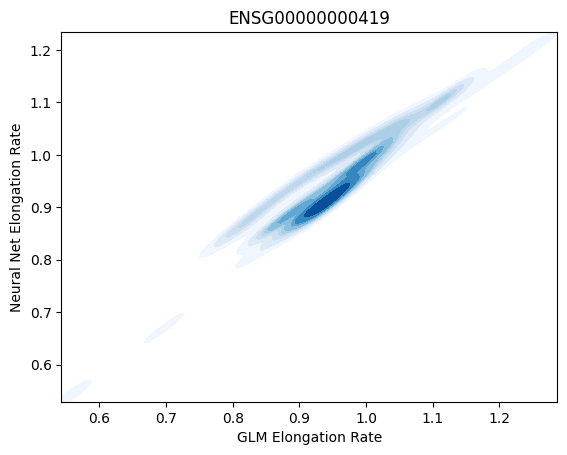

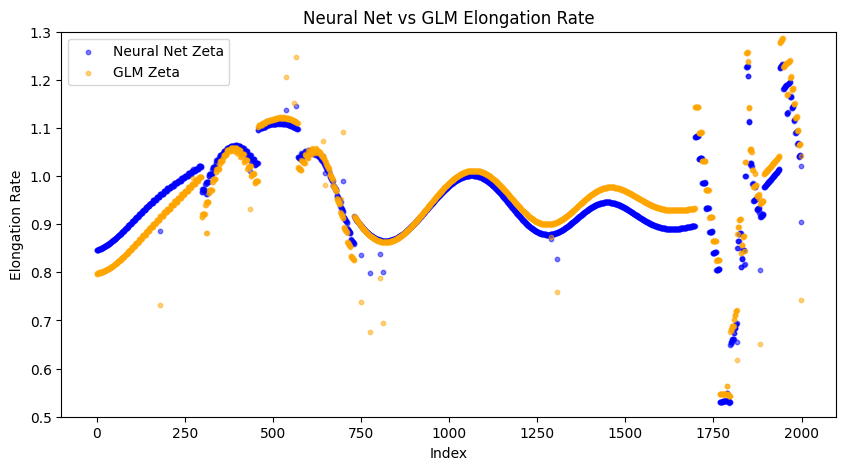

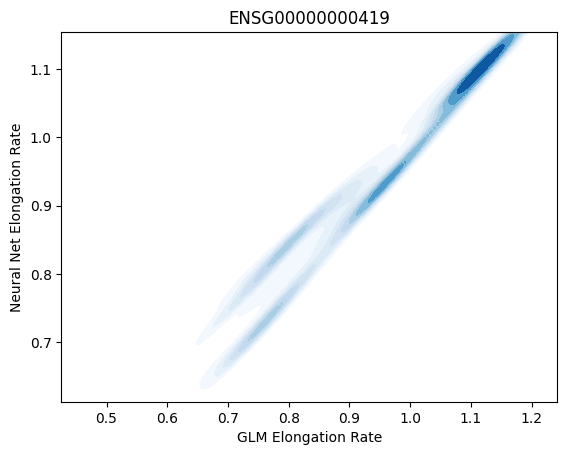

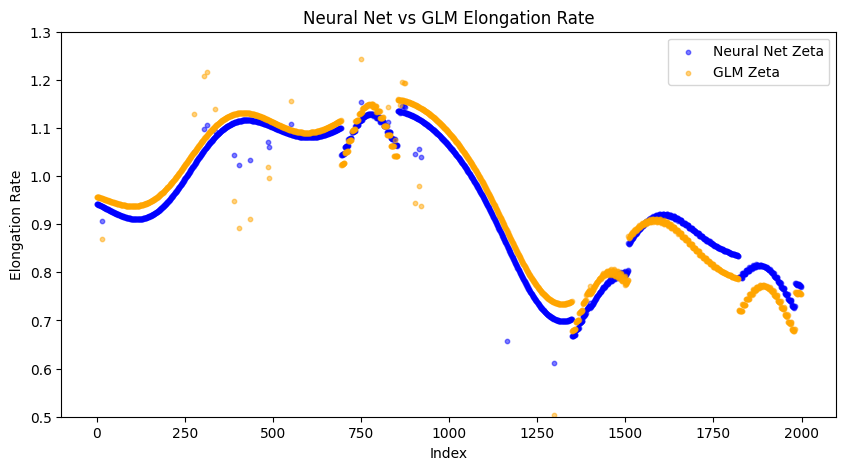

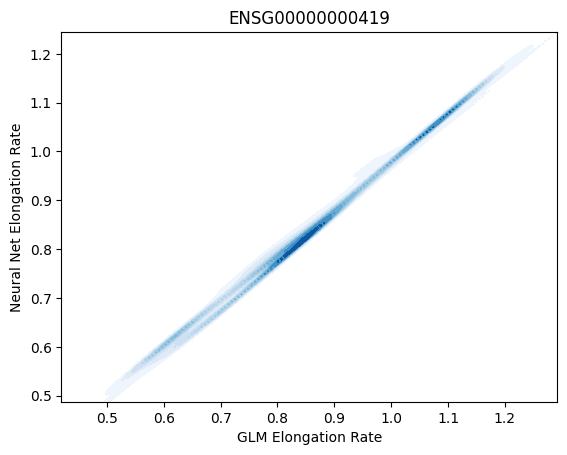

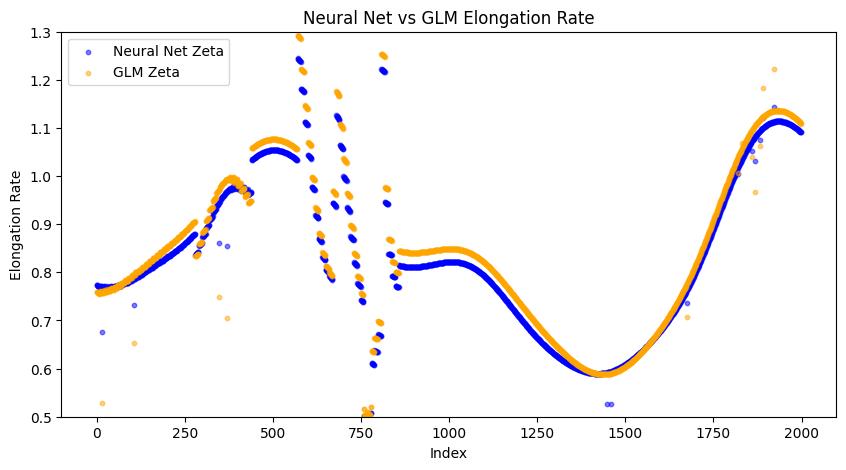

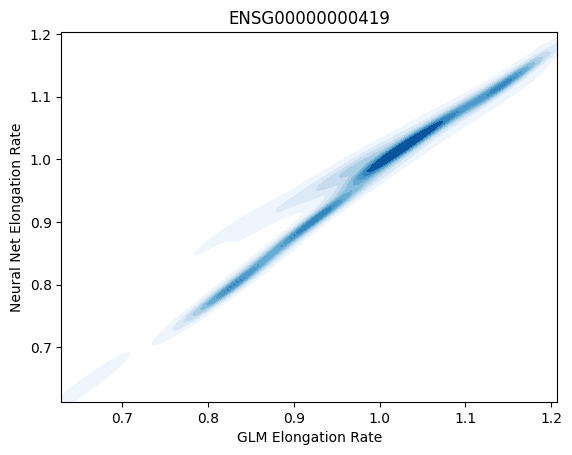

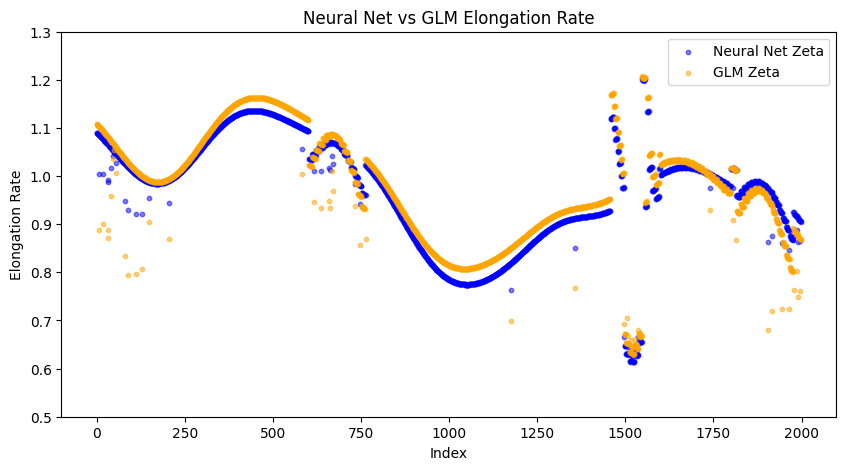

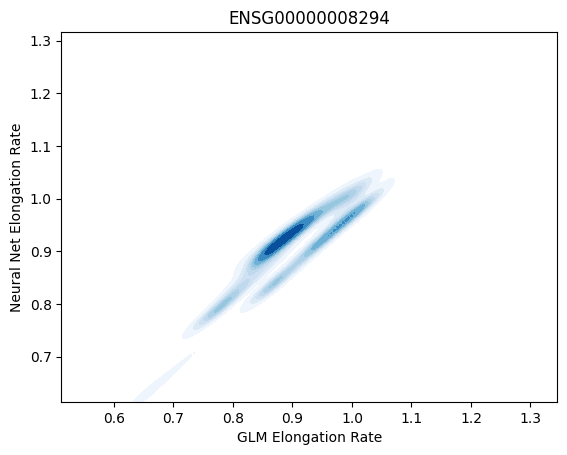

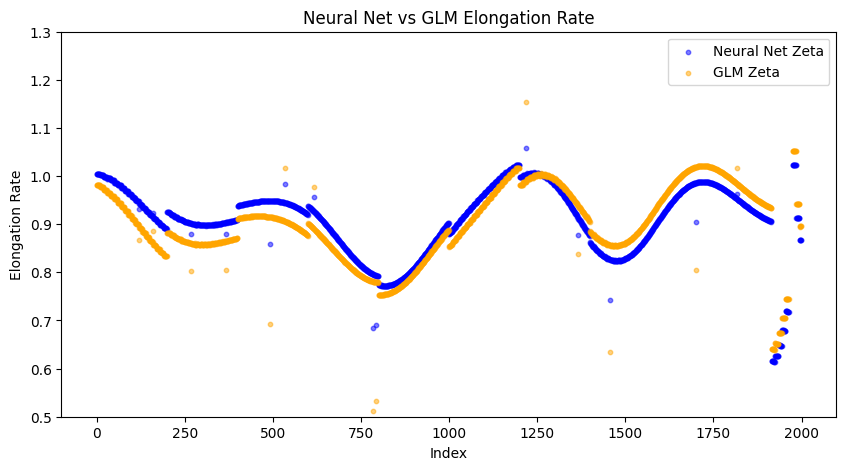

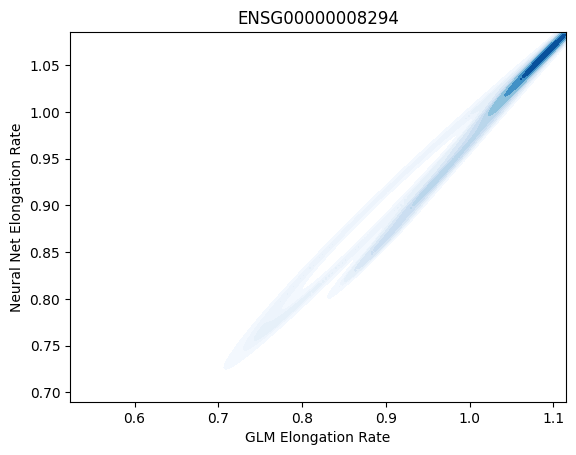

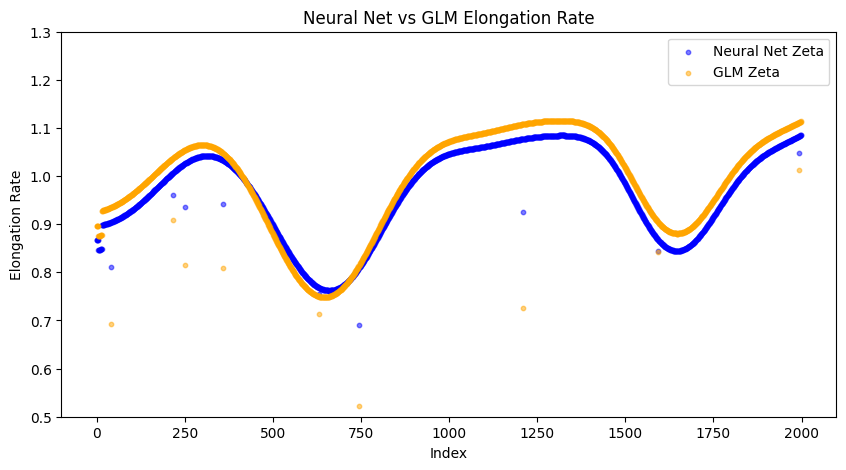

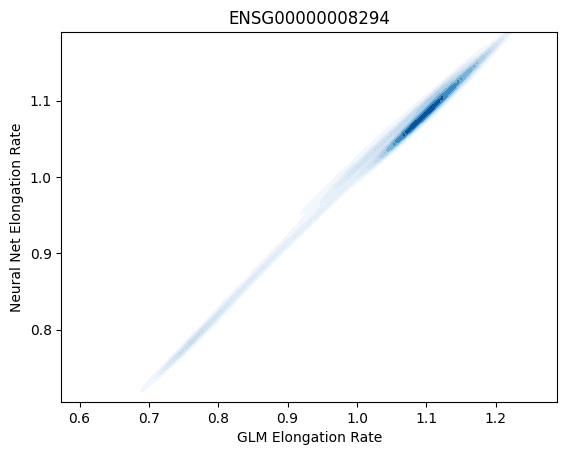

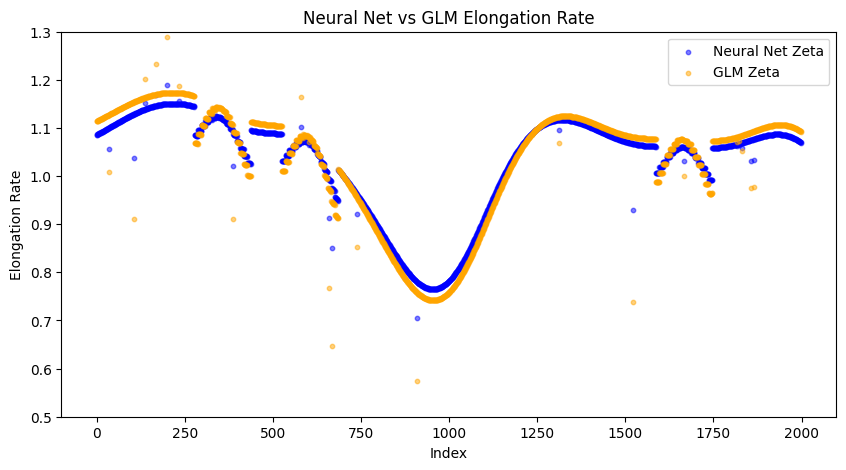

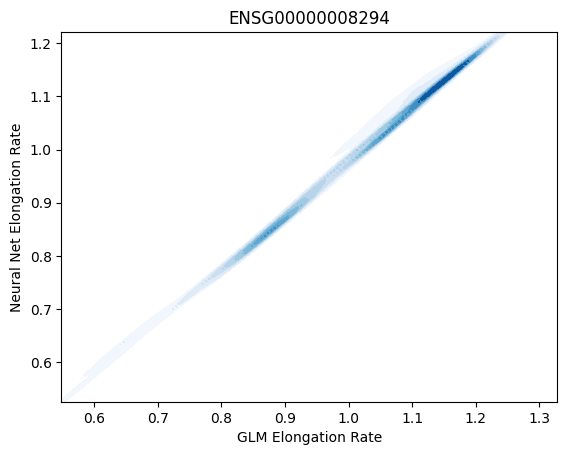

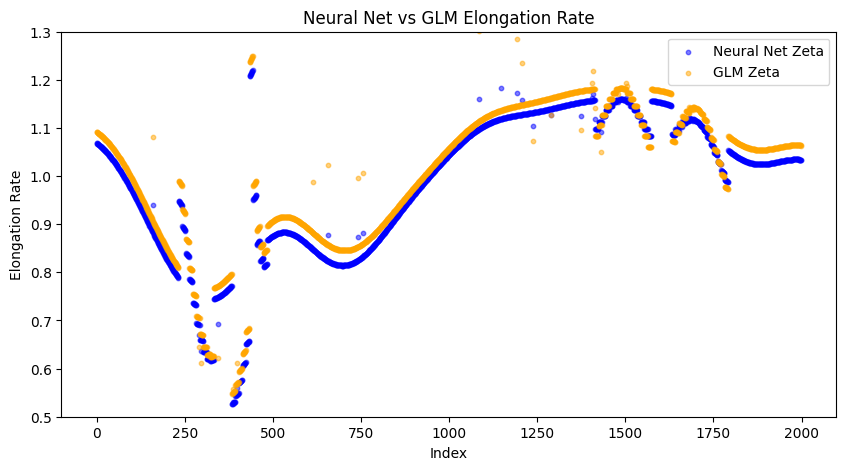

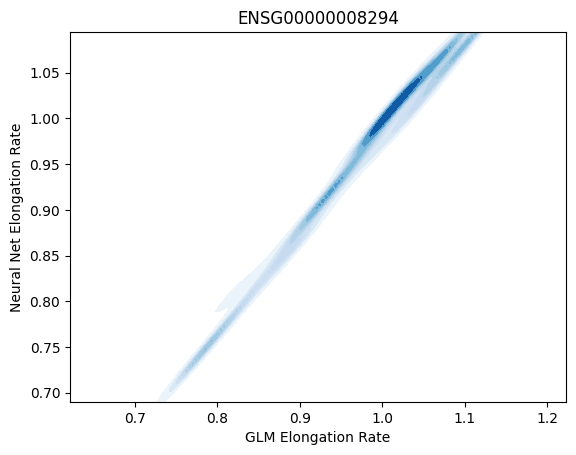

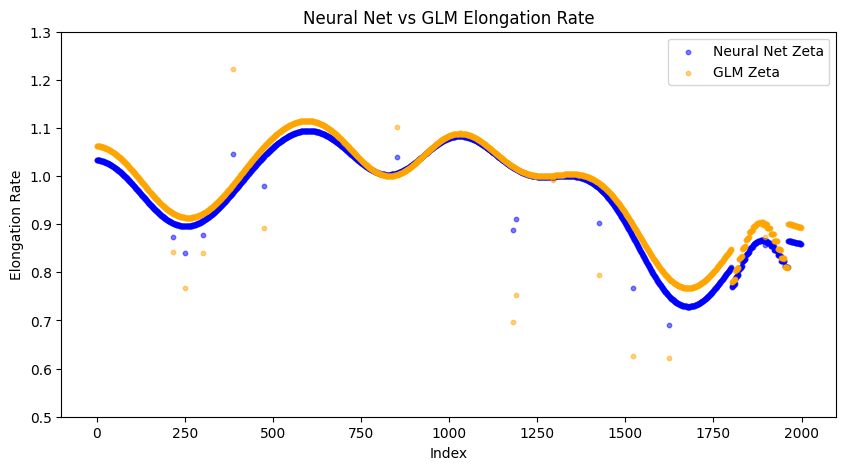

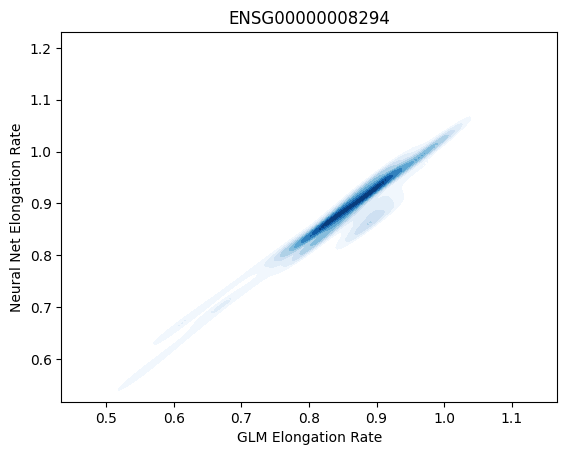

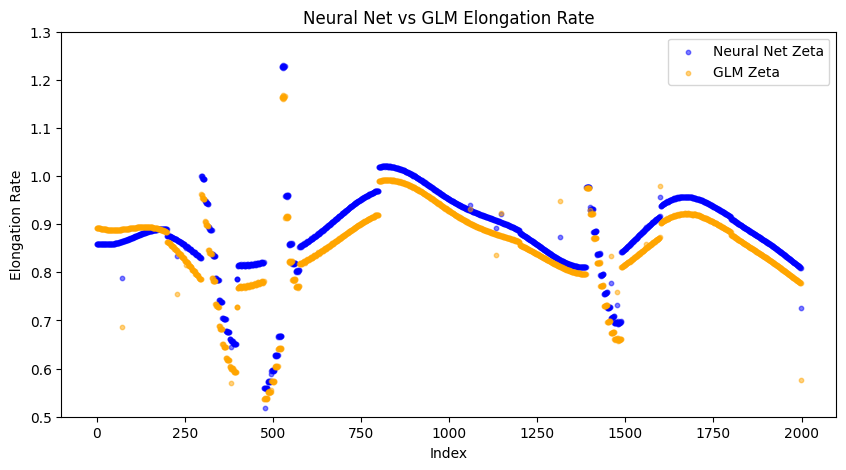

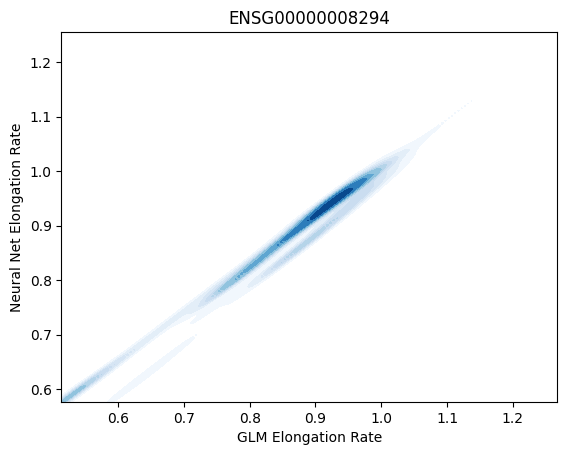

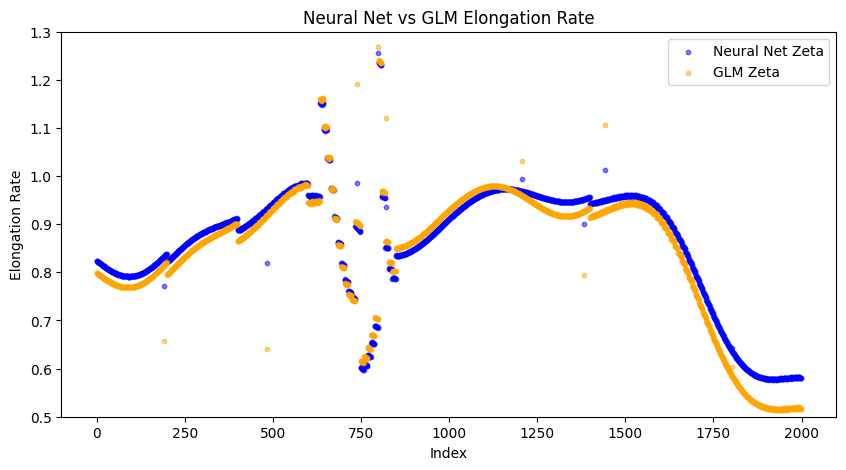

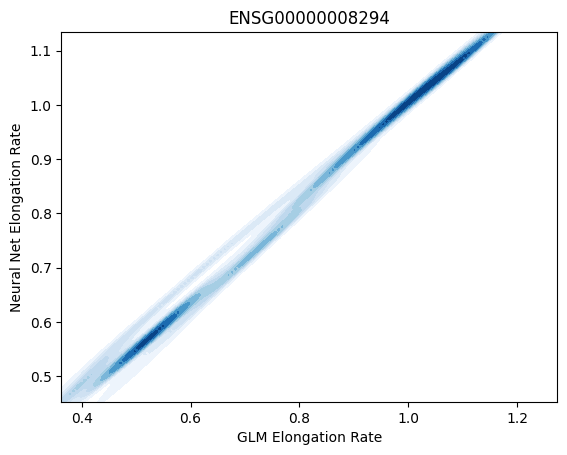

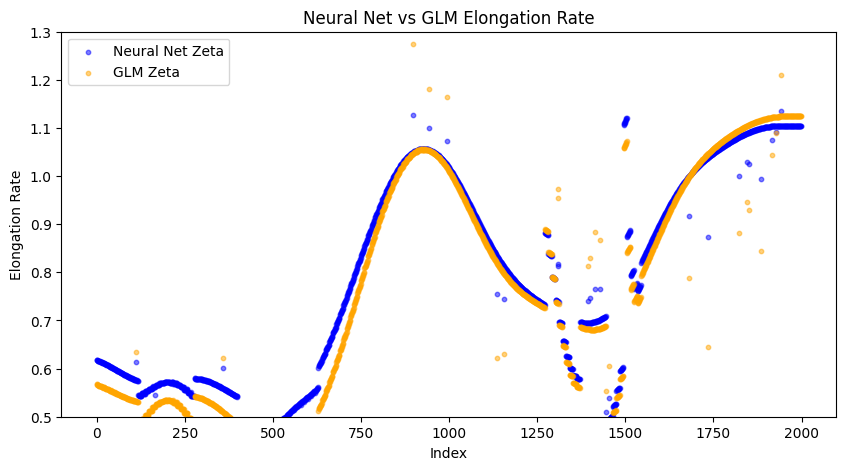

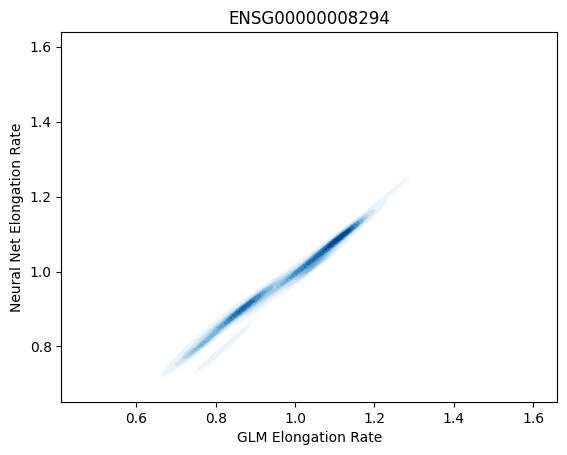

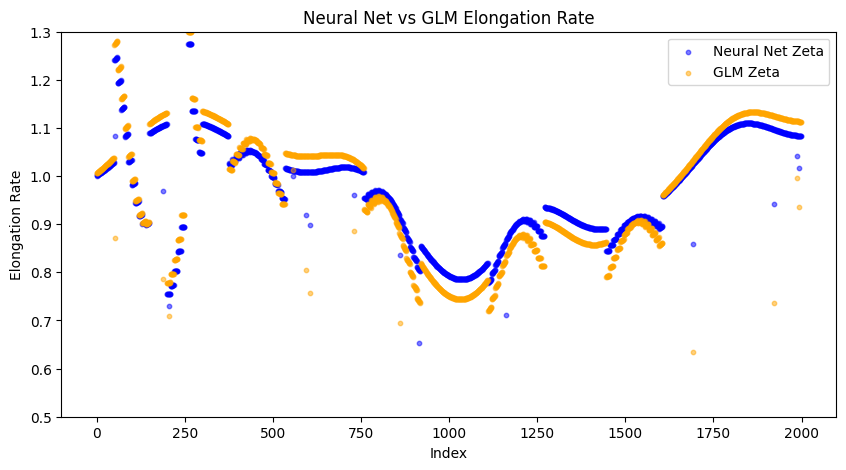

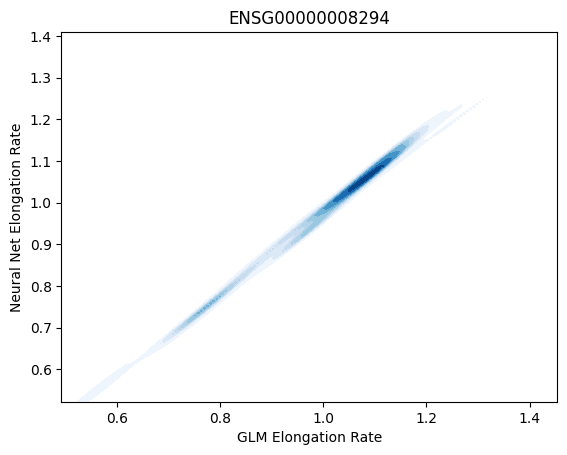

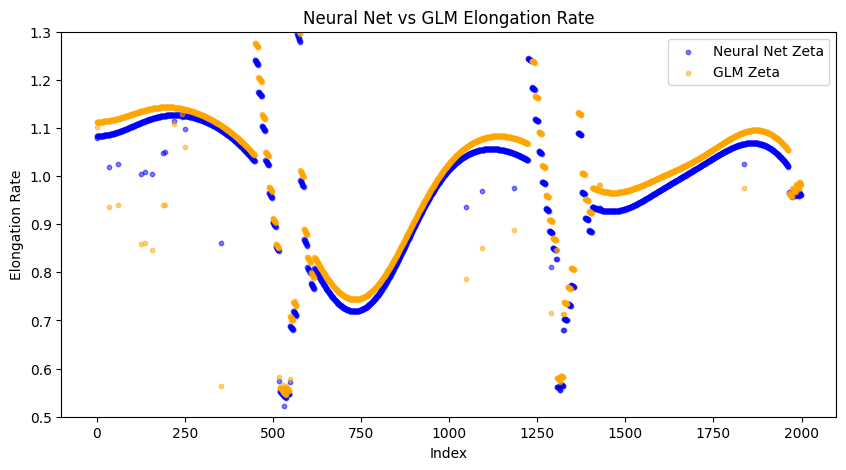

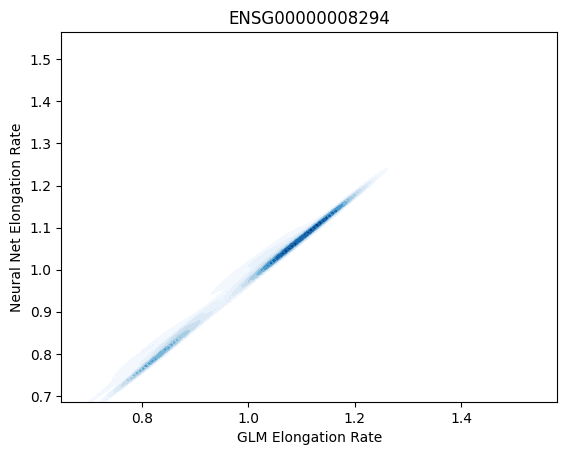

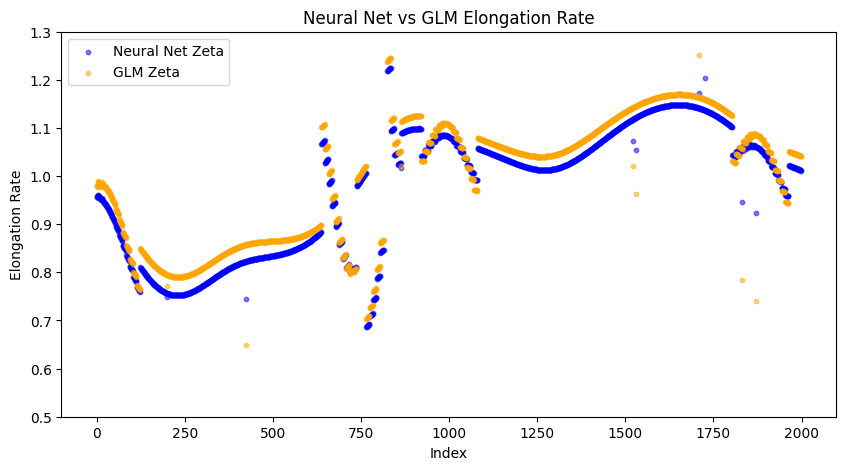

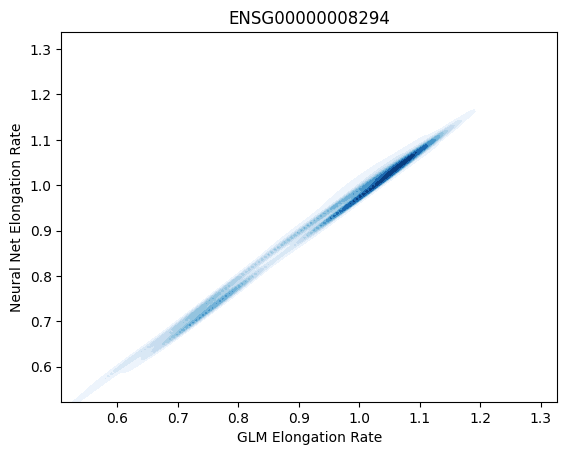

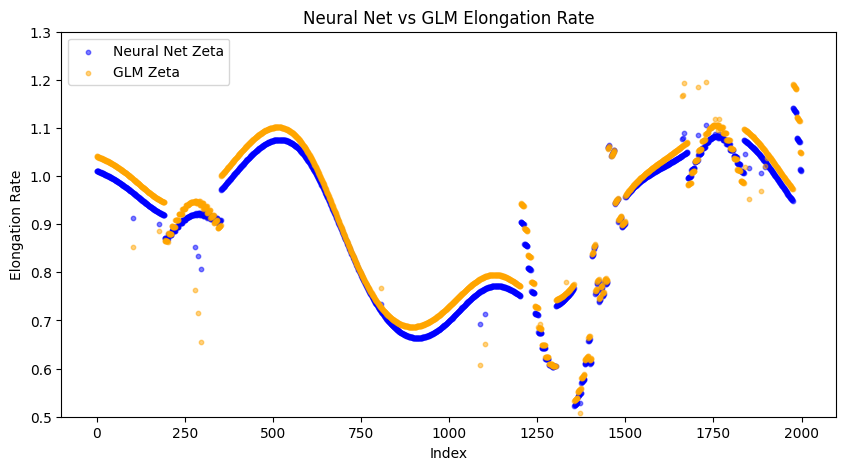

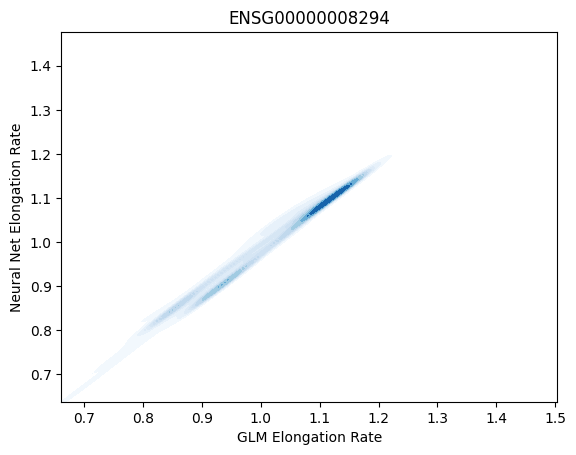

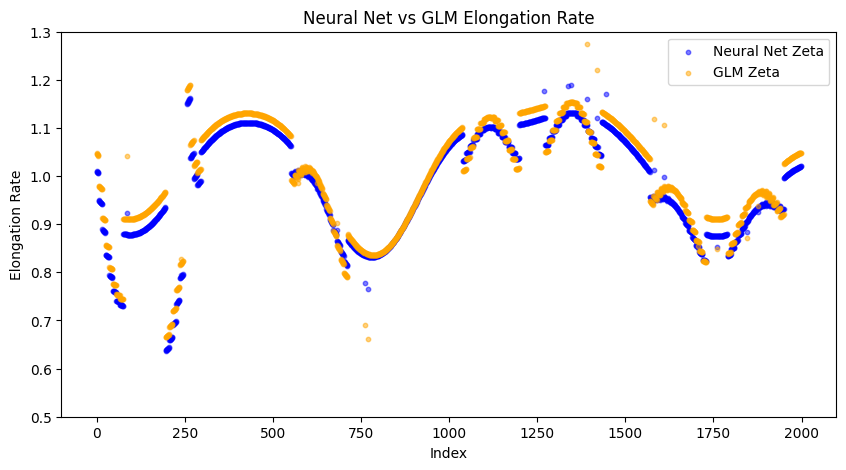

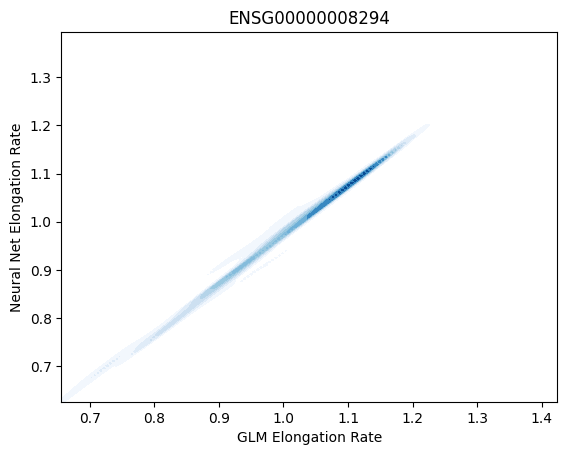

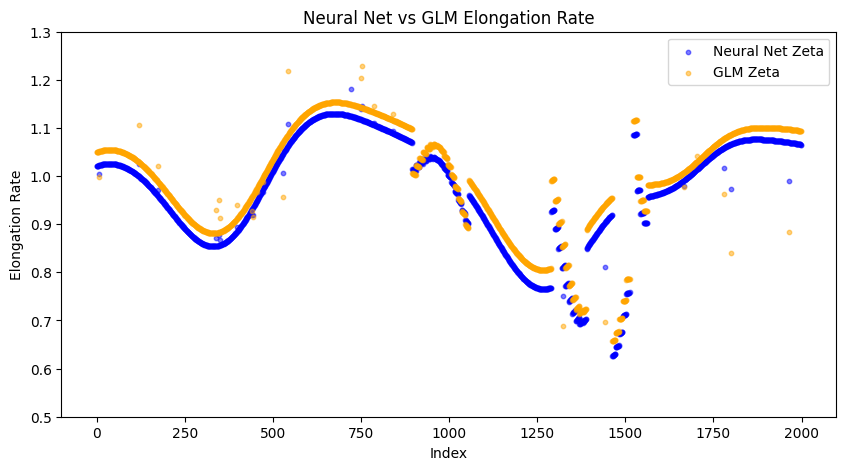

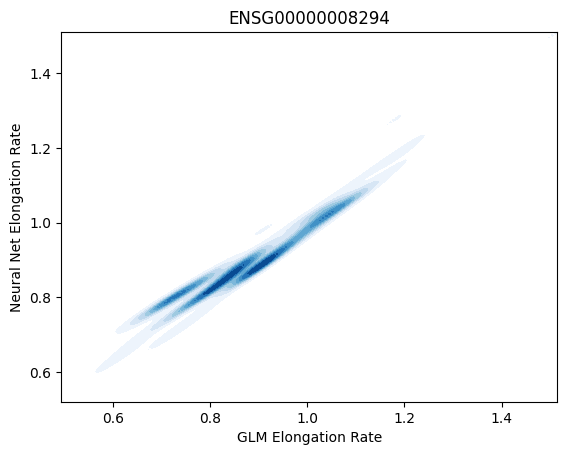

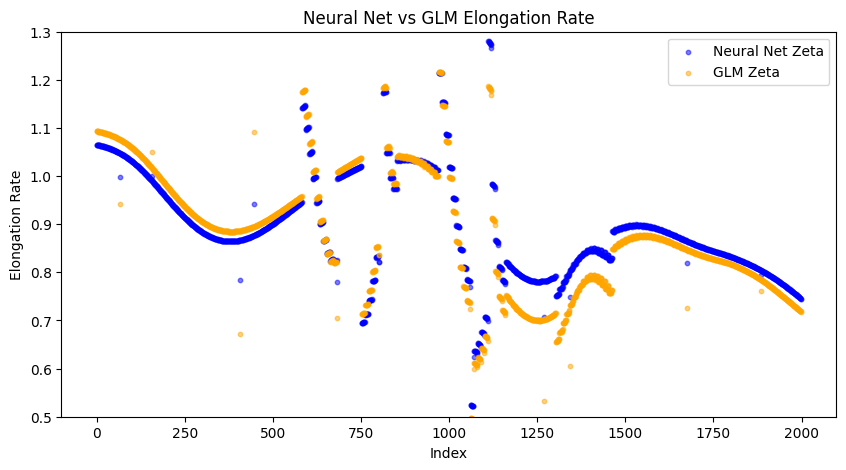

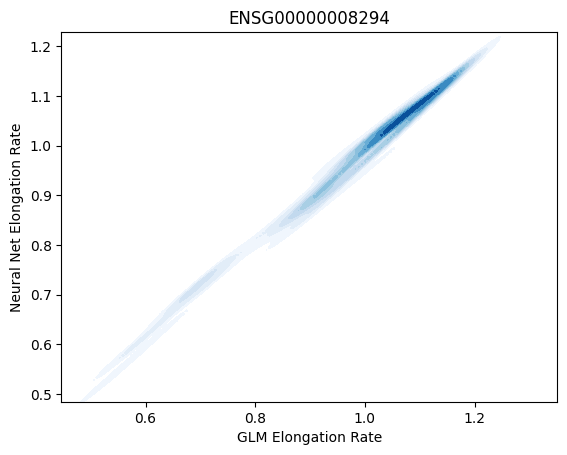

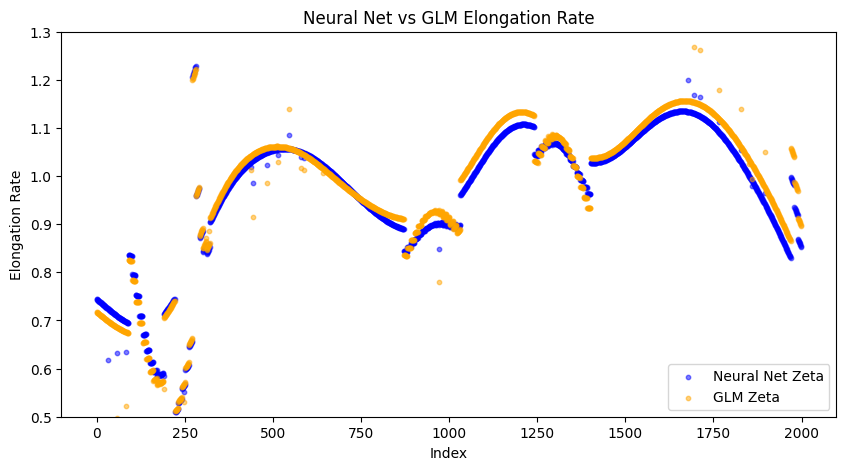

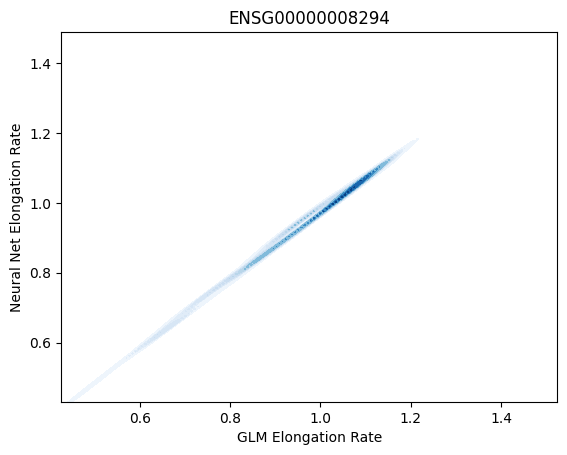

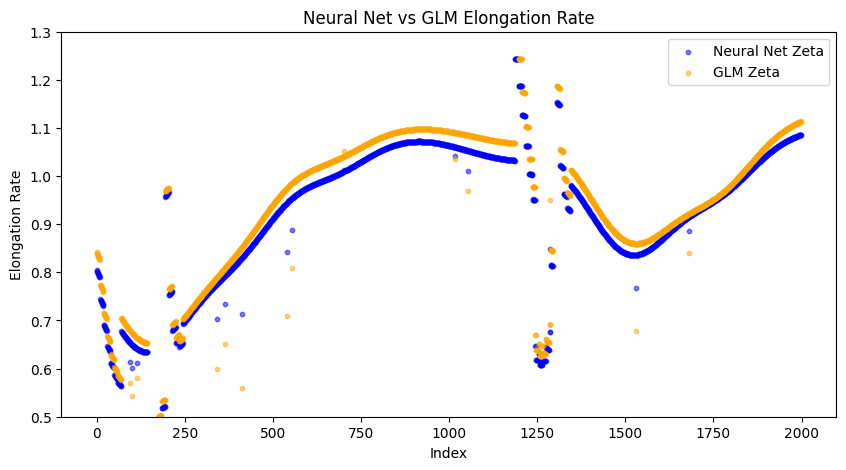

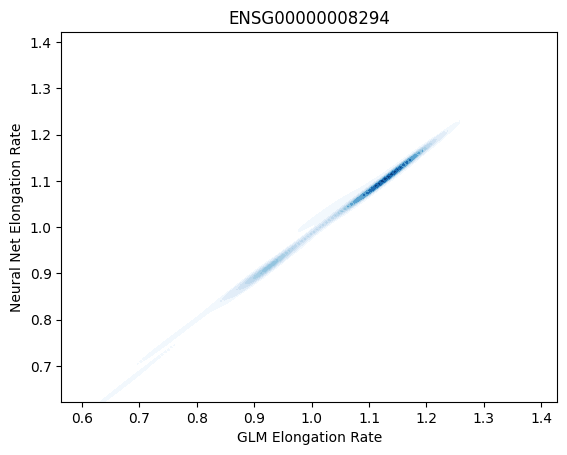

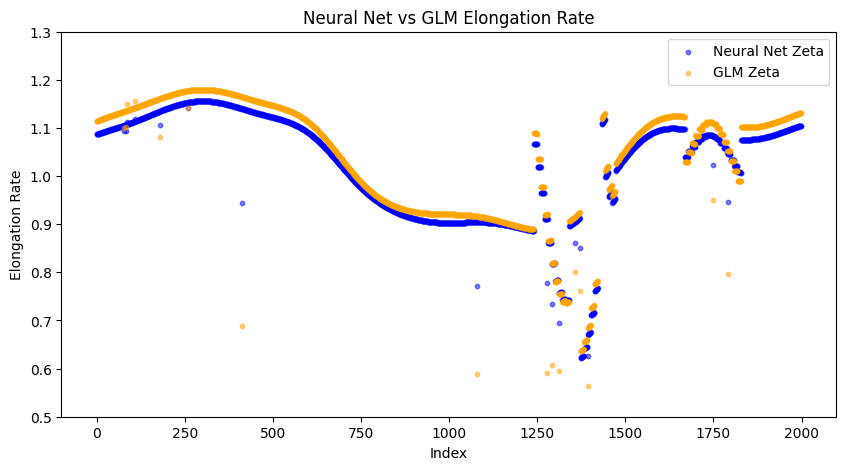

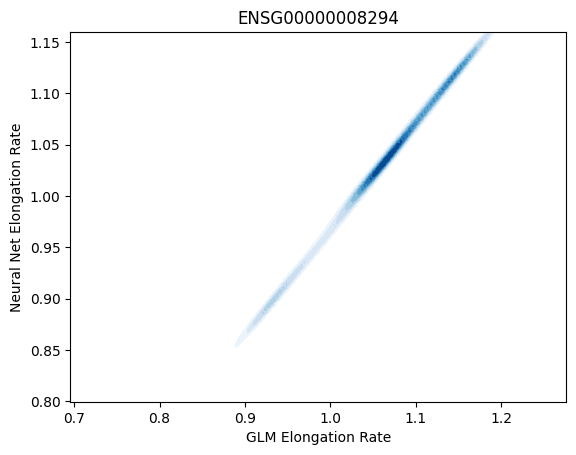

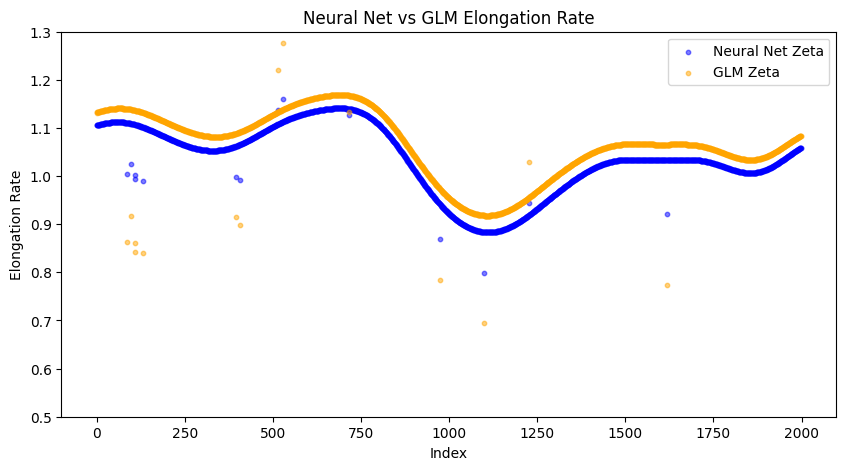

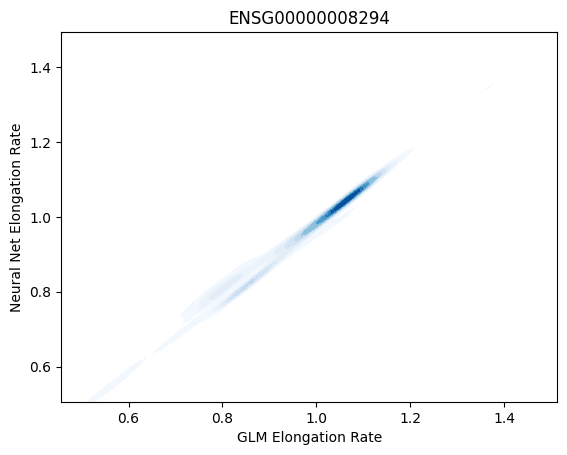

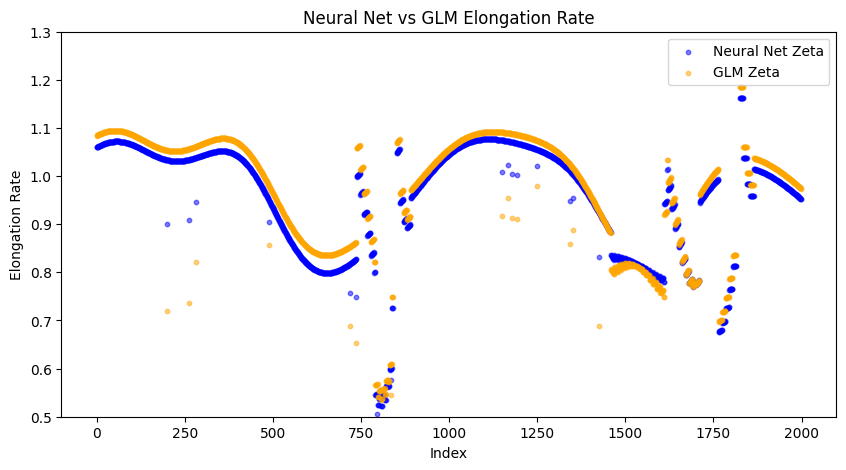

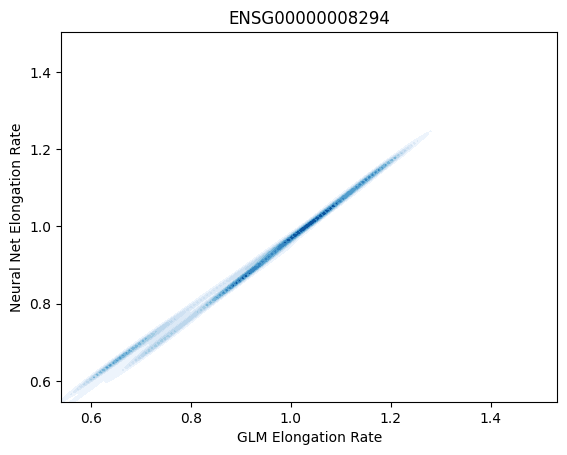

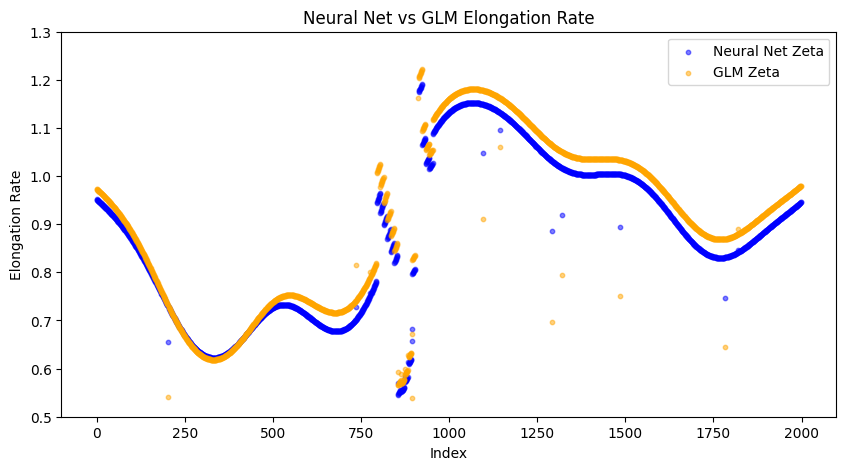

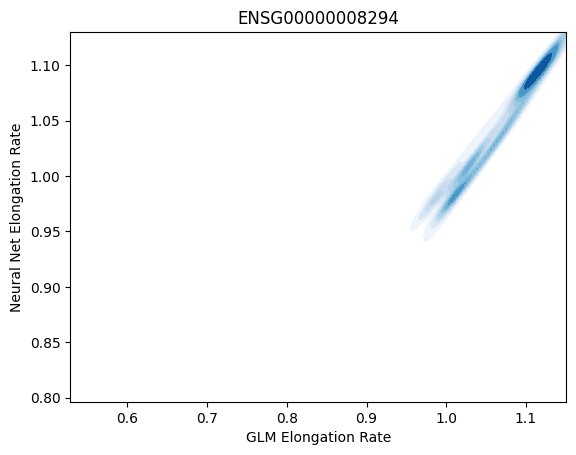

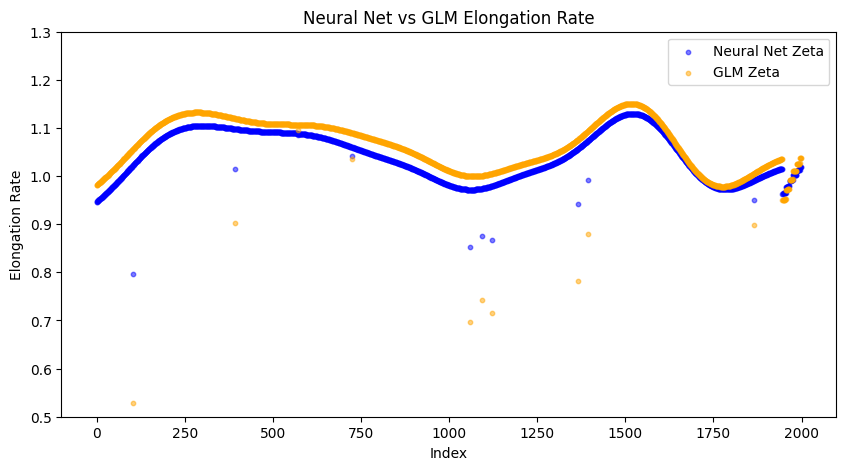

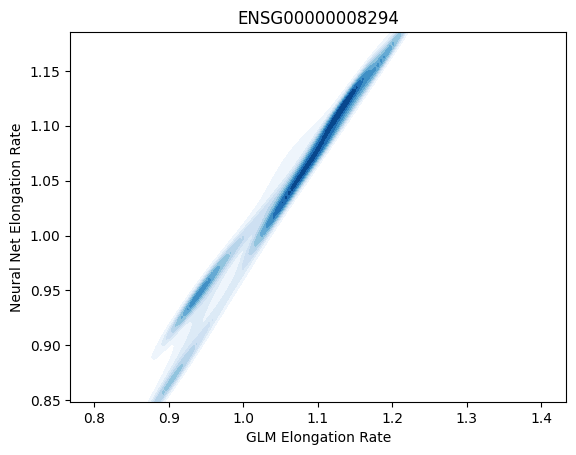

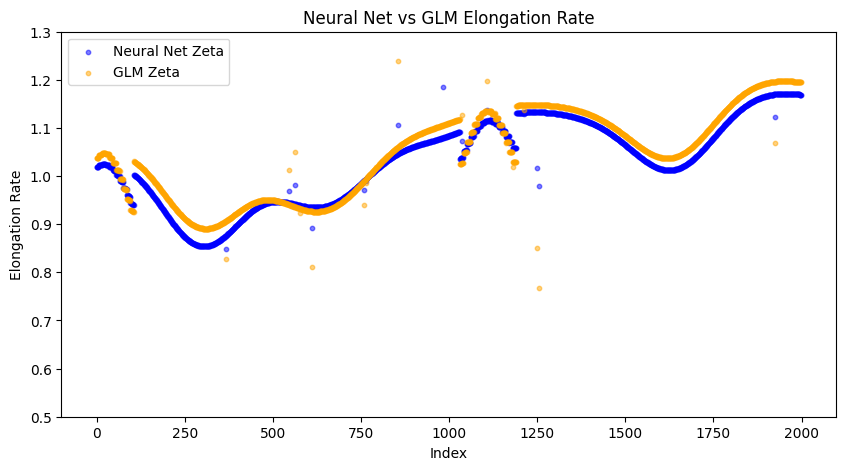

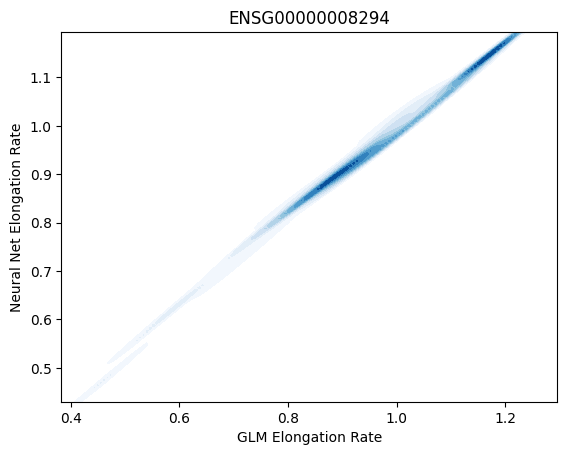

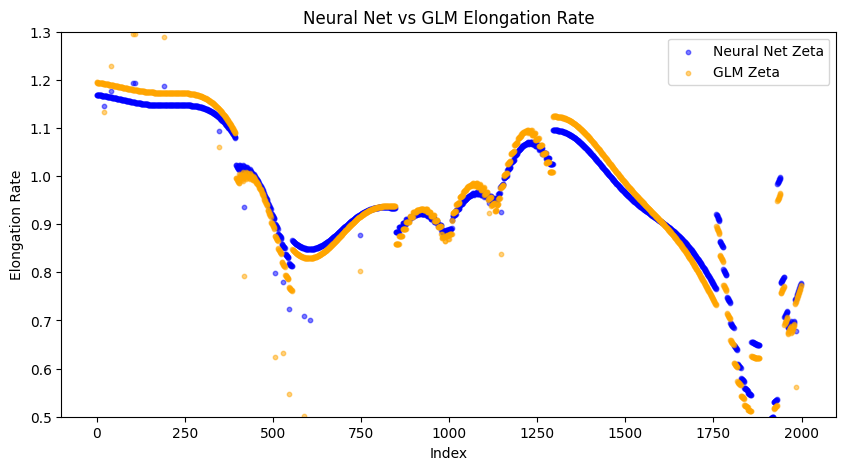

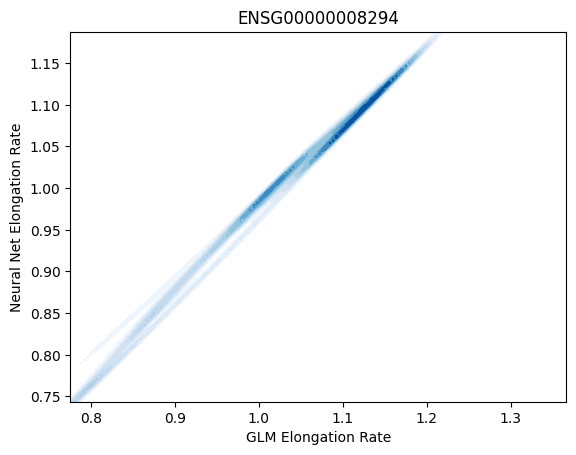

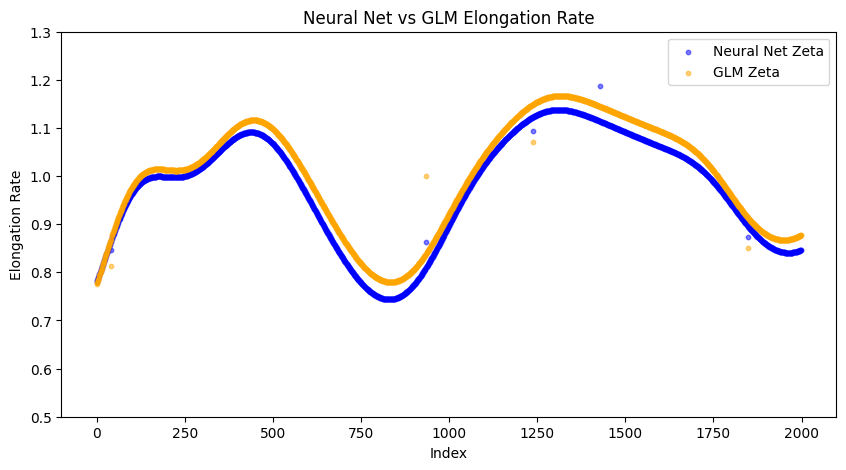

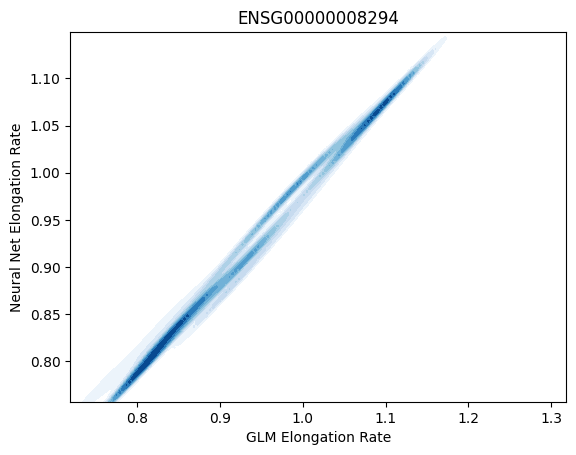

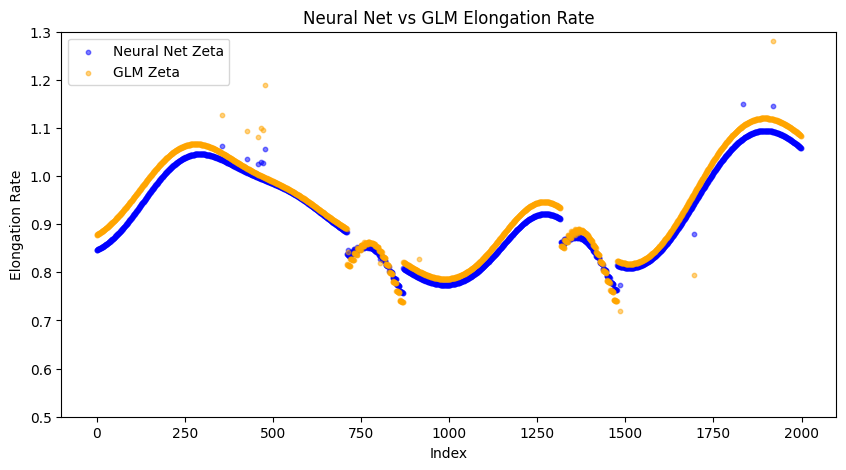

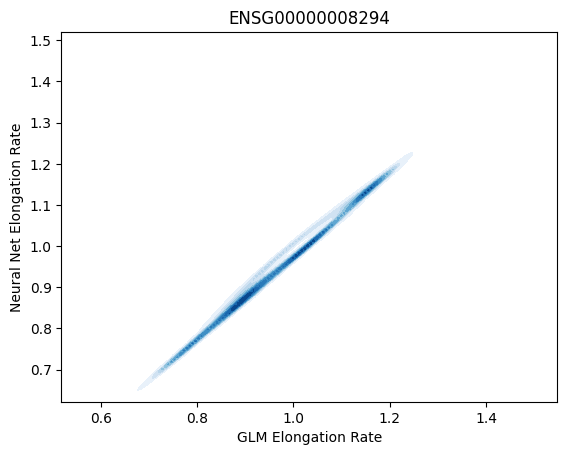

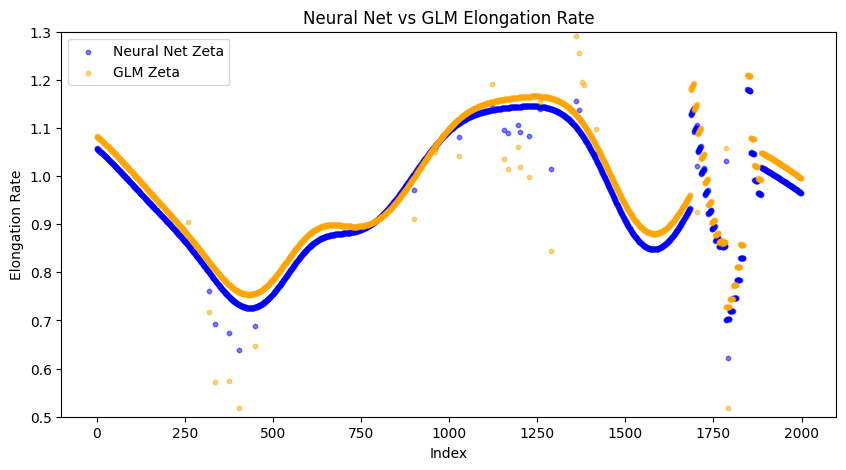

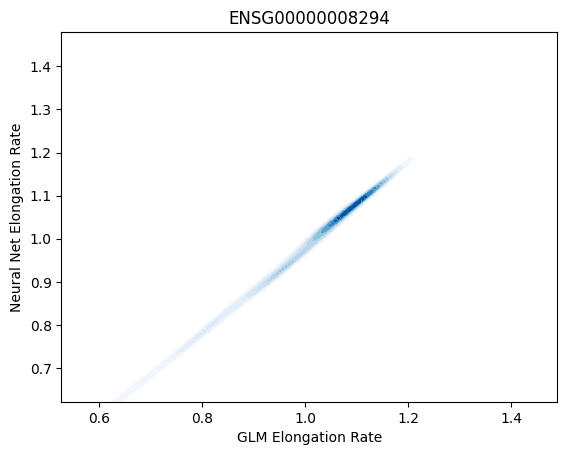

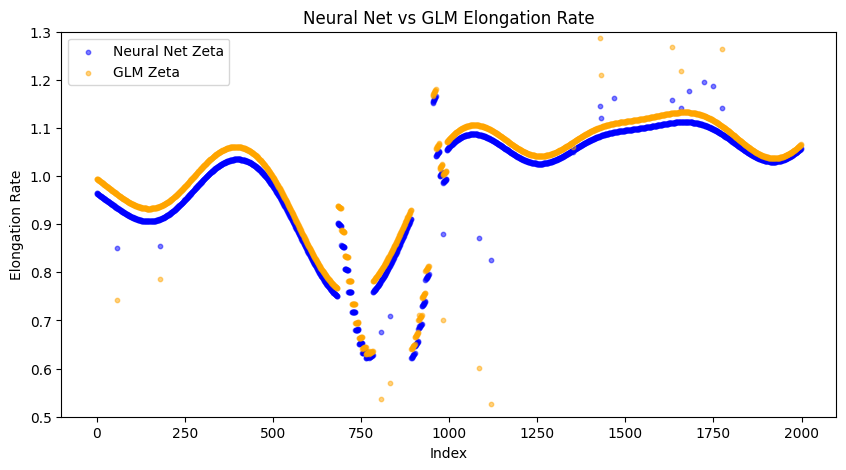

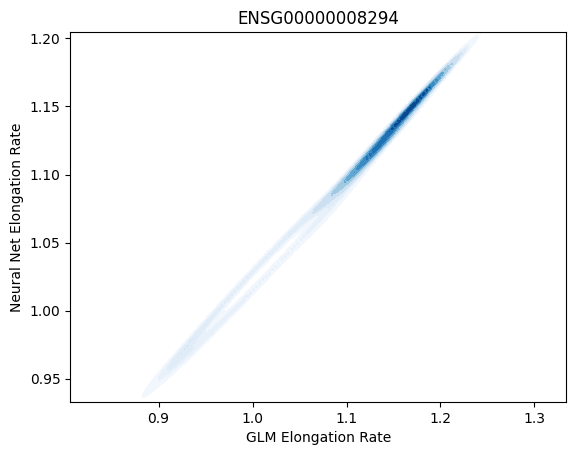

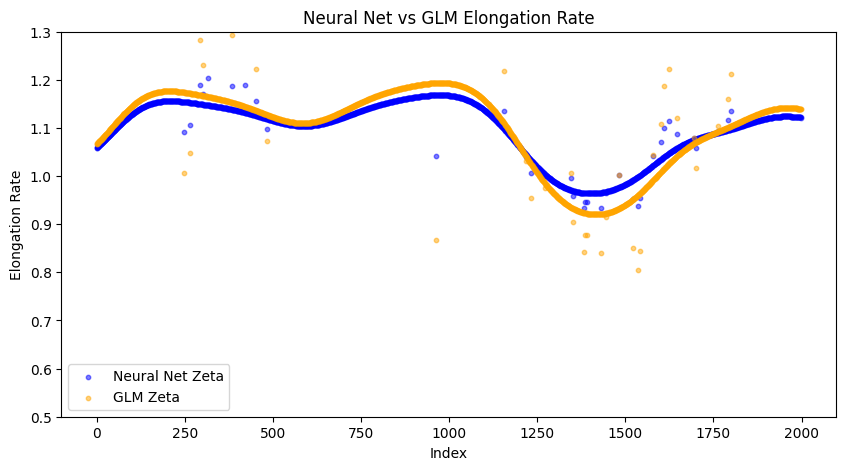

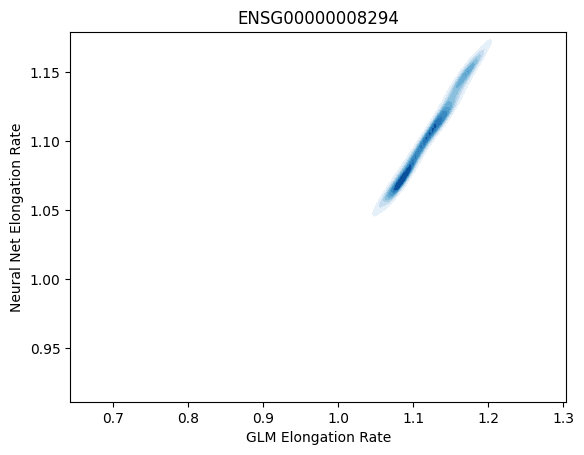

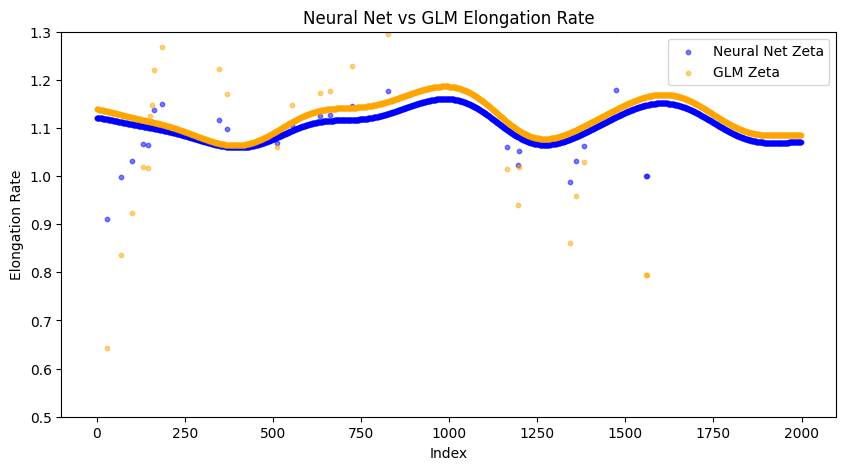

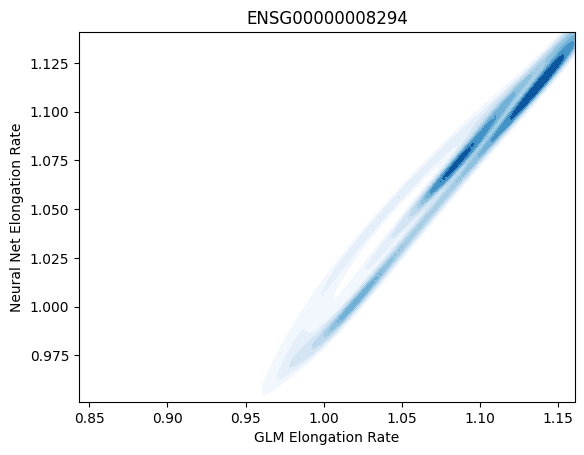

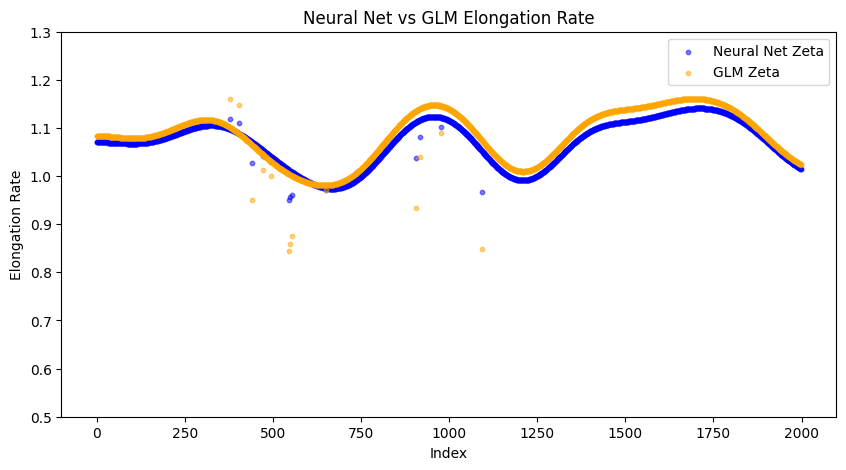

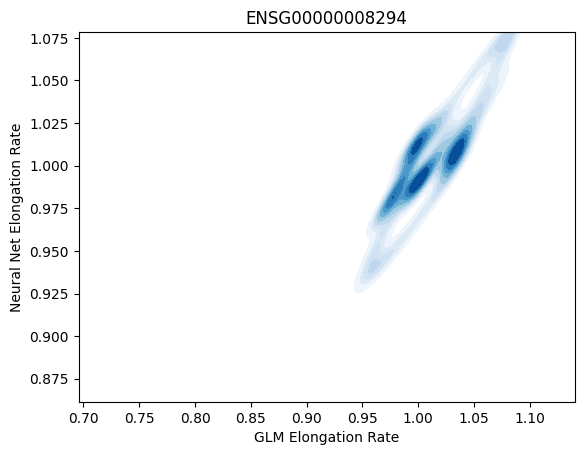

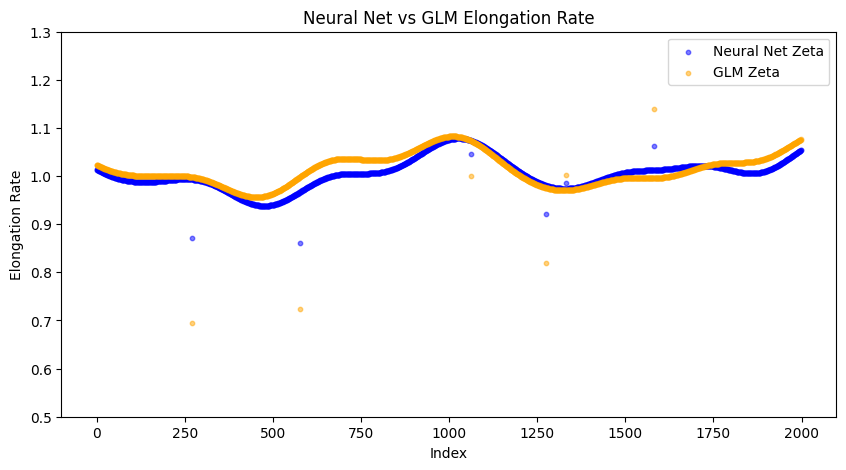

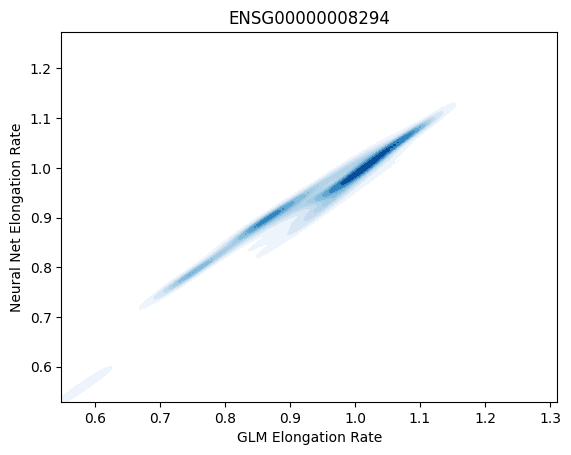

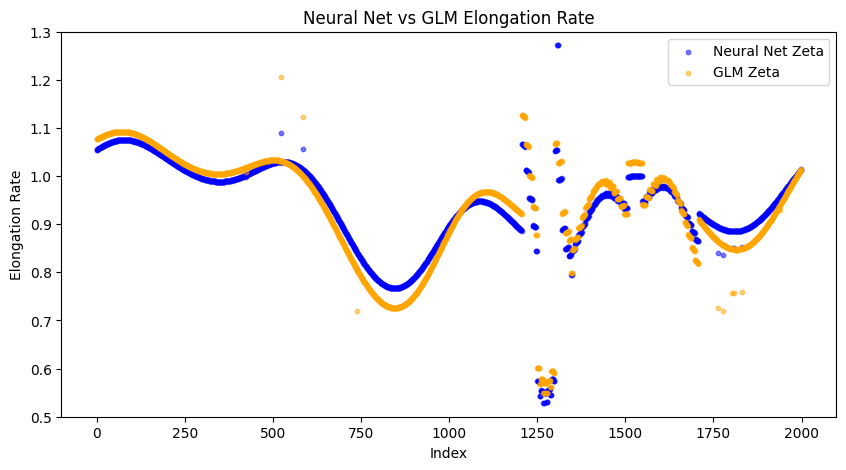

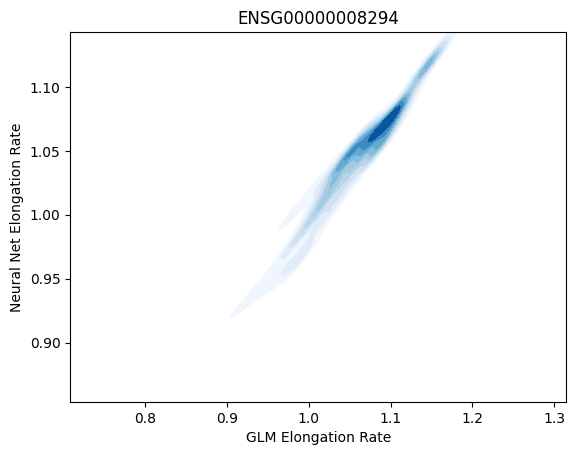

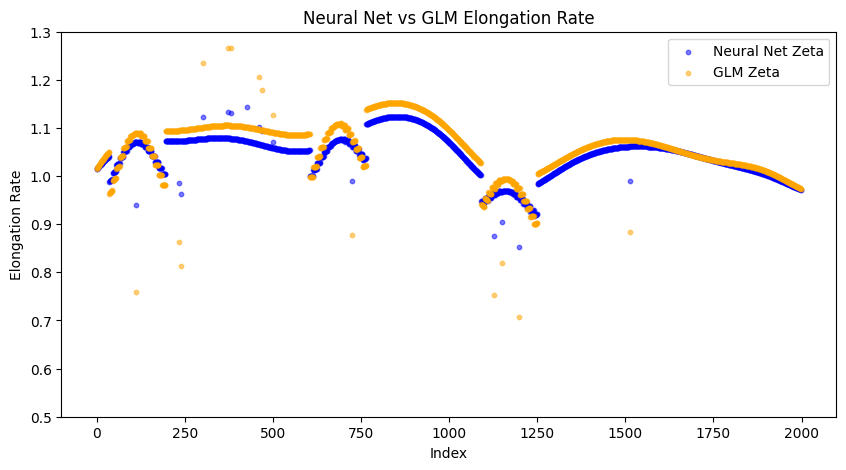

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/grid/siepel/home_norepl/hassett/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/6934129.1.gpu.q/ipykernel_554953/4057770807.py", line 16, in <module>
    density_plot(glm_zeta, net_zeta, gene_id)
  File "/tmp/6934129.1.gpu.q/ipykernel_554953/3340925902.py", line 2, in density_plot
    sns.kdeplot(x=glm_zeta, y=net_zeta, fill=True, cmap="Blues")
  File "/grid/siepel/home_norepl/hassett/.local/lib/python3.7/site-packages/seaborn/distributions.py", line 1743, in kdeplot
    **kwargs,
  File "/grid/siepel/home_norepl/hassett/.local/lib/python3.7/site-packages/seaborn/distributions.py", line 1081, in plot_bivariate_density
    density, support = estimator(*observations, weights=weights)
  File "/grid/siepel/home_norepl/hassett/.local/lib/python3.7/site-packages/seaborn/_statistics.py", line 194, in __call__
    return self._eval_bivariat

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x1552dd893dd0> (for post_execute):


KeyboardInterrupt: 

In [43]:
total_loss = 0
loss_fn = CustomLoss()
for batch in tstdl2:
    gene_id = batch['GeneId'][0]
    model.eval()
    #print("number of samples: " + str(len(batch)))

    with torch.no_grad():
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
    
    glm_zeta = batch['Z_ji'][0]
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())
        
    density_plot(glm_zeta, net_zeta, gene_id)
                
    plot_data(glm_zeta, net_zeta)

In [ ]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=glm_kappa, y=weights[0])

for i in range(len(glm_kappa)):
    plt.text(glm_kappa[i], weights[0][i], feature_names[i], fontsize=13, ha='right', va='top')
plt.xlabel('GLM Weights')
plt.ylabel('Neural Net Weights')

max_val = max(np.max(glm_kappa), np.max(weights[0])) + 0.04
min_val = min(np.min(glm_kappa), np.min(weights[0])) - 0.04

plt.xlim(max_val, min_val)
plt.ylim(max_val, min_val)

# Show the plot
plt.show()

In [ ]:
# profiling code
"""
def print_profiler_results(profiler):
    print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    on_trace_ready=print_profiler_results,
    record_shapes=True,
    profile_memory=True
) as profiler:

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')
        model.train()
        trndl = DataLoader(train_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
        for i, batch in enumerate(trndl):
            optimizer.zero_grad()
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            profiler.step()
        loss_hist_train[epoch] /= len(trndl)
        del trndl
"""

In [ ]:
# sparse loss function
"""
def sparse_dense_mul(s, d):
    i = s._indices()
    v = s._values()
    dv = d[i.squeeze()]
    return torch.sparse.FloatTensor(i, v * dv, s.size())

def sparse_dense_add(s, d):
    s = s.to(d.device)

    indices = s._indices()
    if indices.dim() == 1:
        indices = indices.squeeze()
    values = s._values()

    d[indices] += values

    return d

class SparseCustomLoss(nn.Module):
    def __init__(self):
        super(SparseCustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        C_j_value = C_j[0]
        X_ji = X_ji.squeeze(0)
        rho_ji = rho_ji.squeeze(0).squeeze(1)
        #X_ji_sparse = X_ji.to_sparse()
        #term1 = sparse_dense_mul(X_ji_sparse, rho_ji)
        #term2 = C_j_value * torch.exp(-rho_ji)
        #loss = sparse_dense_add(term1, term2)
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji)
        return (loss).mean()
"""